
Напишем callback, который будет выводить на каждой эпохе:

1. Текущую mae
2. График mae по всем эпохам на обучающей и проверочная выборках
3. Текущий scatter
4. Текущую гистограмму ошибок
5. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения
6. Изменяется ли шаг обучения, если начинается “пила” или mae выходит на плато
7. Сохраняет в .h5 сеть с лучшей точностью



In [ ]:
# определим свой класс для Callback
class CustomCallback(Callback):
    def __init__(self, training_data):
      super().__init__()                            # вызов конструктора родительского класса для совместимости
      self.training_data = training_data            # инициализируем тестовую выборку атрибут класса
      self.train_datetime_start = datetime.datetime.now() # datetime старта обучения
      self.epoch_time_start = time.time()           # время старта эпохи
      self.mae = []                                 # все mae за эпоху
      self.val_mae = []                             # все валидационные mae за эпоху
      self.best_val_mae = np.inf                    # лучшая точность на проверочной выборке
      #
      #self.last_mae = np.inf                        # прошлый mae
      self.cur_mae = np.inf                         # текущий mae
      self.mae_min = np.inf                         # минимальный mae
      self.mae_max = 0                              # максимальный mae
      self.last_state = 'down'                      # прошлое значение положения относительно mae_min и mae_max
      self.cur_state = 'down'                       # текущее значение положения относительно mae_min и mae_max
      self.cross_flag = False                       # флаг было ли пересечение mae вниз или вверх средней от mae_min и mae_max
    
    def on_epoch_begin(self, epoch, logs=None):
      self.epoch_time_start = time.time()


    def on_epoch_end(self, epoch, logs):
      # предскажем текущим состоянием модели нашу проверочную выборку
      pred = self.model.predict([self.training_data[0], self.training_data[1]]) #Полуаем выход сети на проверочно выборке
      predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
      yTrainUnscaled = yScaler.inverse_transform(self.training_data[2]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
      delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
      absDelta = abs(delta) #Берём модуль отклонения

      # добавить все mae в наблюдения текущей эпохи
      self.mae.append(logs['mae'])
      self.val_mae.append(logs['val_mae'])
      # берем val_mae для того чтобы определить "пилу" и "плато"
      self.cur_mae = logs['val_mae']             


      plt.figure(1, figsize=(25,7)) # задаем размер полотна
      # График mae по всем эпохам на обучающей и проверочная выборках
      plt.subplot(131) # указываем, что хотим создать дополнительный подграфик: 2 - количество строк, 1 - количество столбцов, 1 - какой по счету этот график
      plt.plot(self.mae, label='Средняя абсолютная ошибка на обучающем наборе')
      plt.plot(self.val_mae, label='Средняя абсолютная ошибка на проверочном наборе')
      plt.xlabel('Эпоха обучения')
      plt.ylabel('Средняя абсолютная ошибка')
      plt.legend(loc='upper left')
      plt.grid()
      #clear_output(wait=True)
      #plt.show()

      # Текущий scatter
      plt.subplot(132) # указываем, что хотим создать дополнительный подграфик: 2 - количество строк, 1 - количество столбцов, 1 - какой по счету этот график
      plt.scatter(predUnscaled, yTrainUnscaled)
      #plt.plot([0, 1e+9], [0, 1e+9])
      plt.xlabel('Правильные значение')
      plt.ylabel('Предсказанные')
      plt.grid() 
      plt.axis('equal') # делаем оси равного размера
      plt.xlim(plt.xlim())
      plt.ylim(plt.ylim())
      #plt.show()
      
      # Текущую гистограмму ошибок
      plt.subplot(133) # указываем, что хотим создать дополнительный подграфик: 2 - количество строк, 1 - количество столбцов, 1 - какой по счету этот график
      # plt.xlim(0, 0.5)
      # plt.xlim(plt.xlim())
      plt.ylim(0, 10)
      plt.hist(absDelta, bins=40)
      plt.xlabel('Значение ошибки')
      plt.ylabel('Количество')
      plt.grid()

      clear_output(wait=True) # очистка ячейки вывода
      plt.show() # вывод

      # Вывод текущую mae (нескалированного значения) ошибки
      #print("Эпоха", epoch+1, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) # Выводим усреднённую ошибку в миллионах рублей
      print("Эпоха", epoch+1, "модуль ошибки(unscaled)", round(absDelta.mean()/1e+6,3))          # Выводим усреднённую ошибку в миллионах рублей

      # время обучения на эпоху
      current_datetime = datetime.datetime.now() # текущая дата
      delta_datetime = current_datetime - self.train_datetime_start # разница с момента старта обучения
      datetime_for_epoch = delta_datetime / (epoch+1) # среднее время на эпоху
      all_epochs = self.params['epochs'] # всего эпох
      left_epochs = all_epochs - (epoch+1) # осталось эпох
      this_epoch_time = time.time() - self.epoch_time_start                # время обучения на эпохе уже в секундах
      all_train_time = (all_epochs * datetime_for_epoch).total_seconds()   # время обучения суммарное в секундах
      left_train_time = (left_epochs * datetime_for_epoch).total_seconds() # сколько времени остаётся до конца обучения в секундах
      print('Время обучения на эпохе:\t{}\tсекунд\nВремя обучения суммарное:\t{}\tсекунд\nВремени до конца обучения:\t{}\tсекунд'\
            .format(round(this_epoch_time,2),
                    round(all_train_time,2),
                    round(left_train_time,2),
            ))

      # Изменяется ли шаг обучения, если начинается "пила" или mae выходит на плато
      # обновим экстремумы
      if epoch<2: # первых 2 эпох достаточно только чтобы определить глобальный min и max
        if self.cur_mae < self.mae_min: # обновить минимум
          self.mae_min = self.cur_mae
        if self.cur_mae > self.mae_max: # обновить максимум
          self.mae_max = self.cur_mae
      else: # уже есть три последних значения mae, можно увидеть локальный min или max
        if self.val_mae[-3]<self.val_mae[-2]>self.val_mae[-1]:    # развернулись наверху графика
          self.mae_max = self.val_mae[-2]                         # обновим локальный максимум
        elif self.val_mae[-3]>self.val_mae[-2]<self.val_mae[-1]:  # развернулись внизу графика
          self.mae_min = self.val_mae[-2]                         # обновим локальный минимум

      # выставим положение относительно средней между mae_min и mae_max
      if epoch>0: # нулевую эпоху пропускаем т.е. mae_min и mae_max еще не определены
        # найдем линию средней mae
        avg_mae = (self.mae_max + self.mae_min) / 2
        # где мы сейчас относительно средней mae
        if self.cur_mae > avg_mae:    # выше средней линии
          self.cur_state = 'up'
        elif self.cur_mae < avg_mae:  # ниже средней линии
          self.cur_state = 'down'
        # проверим пересекли ли среднюю линию
        if self.last_state != self.cur_state: # было пересечение
          self.cross_flag = True # включить флаг пересечения
      
      # выводим статус обучения
      if self.cross_flag: # флаг пилы установлен
        print('Режим обучения: ПИЛА')
        self.cross_flag = False # можно отключить флаг пилы
      elif (self.last_state == self.cur_state) and (self.cur_state == 'up'):   # держимся выше средней mae
        print('Режим обучения: Плато или переобучение')
      elif (self.last_state == self.cur_state) and (self.cur_state == 'down'): # держимся ниже средней mae
        print('Режим обучения: Нормальный')

      # обновить предыдущие значения
      #self.last_mae = self.cur_mae 
      self.last_state = self.cur_state

      print('Шаг обучения: ', float(get_value(self.model.optimizer.learning_rate)))

      # если это лучший val_mae то сохраним модель в .h5
      if logs['val_mae'] < self.best_val_mae: 
        self.model.save('/content/drive/My Drive/AIFramework/moscow_best_val_mae.h5')
        self.best_val_mae = logs['val_mae'] # обновим лучший результат

# Коллбэки
# pltMae = LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

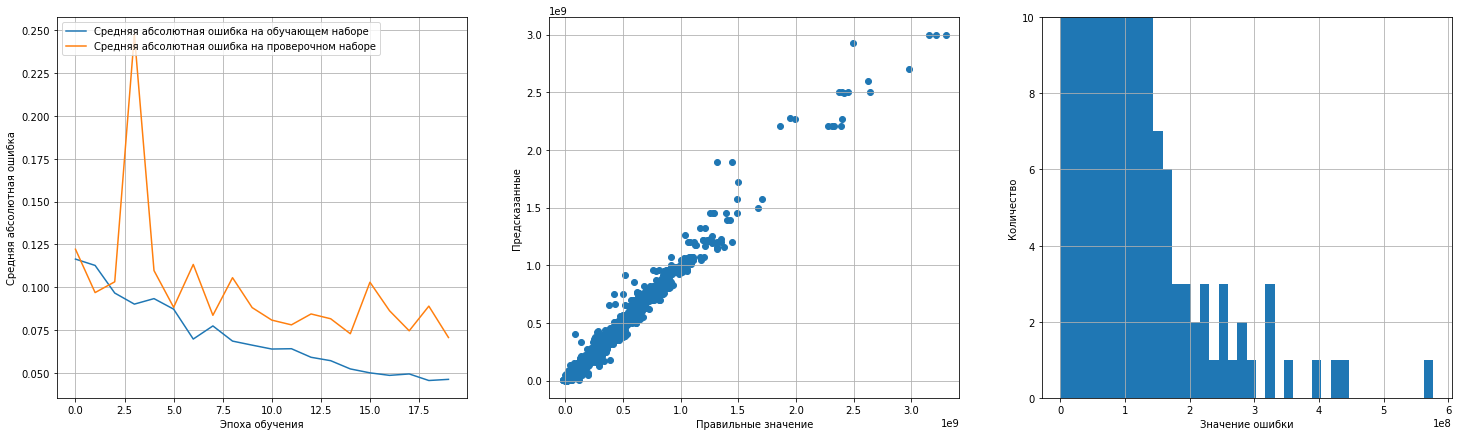

Эпоха 20 модуль ошибки(unscaled) 2.91
Время обучения на эпохе:	7.12	секунд
Время обучения суммарное:	147.45	секунд
Времени до конца обучения:	0.0	секунд
Режим обучения: ПИЛА
Шаг обучения:  0.0010000000474974513


In [ ]:
history = model.fit([xTrainScaled[~val_set], xTrainC01[~val_set]],
                    yTrainScaled[~val_set],
                    epochs=40,
                    batch_size=128,
                    validation_data=([xTrainScaled[val_set], xTrainC01[val_set]],
                                     yTrainScaled[val_set]),
                    verbose=0,
                    callbacks=[CustomCallback( [xTrainScaled[~val_set], xTrainC01[~val_set], yTrainScaled[~val_set]] )]
                    )